# __State Efficient Ansatz__

## __Introduction__


Is usual when we try to solve an optimization problem that the optimizator arrive to a shallow space where the gradient of the cost function vanishes, known as Barren Plateau (BP). Causes of BP are plenty studied in the literature, the most knwon sources are:   __ansatz__, __initial parameters__, __cost function__, __deep of circuit__, __hardware noise__, among others. In this notebook we will tackle the BP induced by the choice of a "bad" ansatz.

In order to optimize the ansatz it should be an universal Parametrized Quantum Circuit (PQC). It said that the PQC is too expressive when the circuit approximate to a 2-design, but in contrast it leads to a poor trainability since the search space is to big to converge to an optimal solution. In this case we have that the average cost function is null and its variance decay exponentially. 

$$ \mathbb{E}( \nabla \langle H\rangle )=0, \qquad {\rm Var}( \nabla \langle H\rangle ) \sim \frac{1}{2^n}.$$

Xiu Liu et al. propose a new kind of ansatz call __State Efficient Ansatz__ (SEA) that removes some redundancy between the universal unitary and universal pure quantum states. In fact the universal unitary group $U(2^{2N})$ have $4^{2N}$ degrees of freedom while a 2N-qubit pure state have $2^{2N +1}-2$ degrees of freedom. SEA close up these gap reducing the total degrees of freedom needed to parametrize the circuit down to $4^N$ obtaining a quadratic speed-up when the number of qubits increases. It is important to remark that since the unitaries $U_1, U_2$ and $U_3$ are near a 2-design in some cases we can remove their own redundancy by making that unitaries close to a 1-design getting the optimal degrees of freedom of $2^{2N+1}-2$ for a pure state [1]. 

The novelty of SEA is the architecture of the ansatz that is composed by gates near to a 2-design but the global circuit is a 1-design circuit. These leads to a great expresibility with good trainability avoiding barren plateaus [1].

<center><img src="https://github.com/jgidi/quantum-barren-plateaus/blob/main/imgs/Conceptualization.jpg?raw=true" width=500 style="display: block; margin: 0 auto"  ><center>

The left column of the previous figure ilustrates the barren plateaus phenomenon for to expressive ansatz. In contrast, the rigth column of the figure shows that SEA makes a trade-off between expressibility and trainability. SEA is composed by four gates, a Schmidt coefficient layer $U_1$, entangling layer $V$ and local basis changing layer $U_2, U_3$. SEA acts over to subsystems A and B [1]. The whole structure can be written as,

$$ SEA( \theta ) \equiv (U_2 (\theta_2) \otimes U_3(\theta_3)) V (U_1 (\theta_1) \otimes I ).$$

In fact the unitaries $U_1, U_2$ and $U_3$ could be the same parametrized Alternating Layered Ansatz (ALT). We use the following circuit,

<center><img src="https://github.com/jgidi/quantum-barren-plateaus/blob/main/imgs/ALT_SEA.jpg?raw=true" width=500 style="display: block; margin: 0 auto"  ><center>

Now that we understand the basis concepts of the State Efficient Ansatz to avoid the barren plateaus phenomenon we are going to see a practical and common use case of VQE, __FIND THE GROUND STATE OF A MOLECULE !__

## __Example:__ Ground State of BeH2

We solve the ground state of BeH2 by reducing the numbers of qubits from 14 to 6, omitting electrons in the bulk and orbitals that correspond to 'very' exited states.

<center><img src="https://github.com/jgidi/quantum-barren-plateaus/blob/main/imgs/beh2.jpg?raw=true" width=300 style="display: block; margin: 0 auto"  ><center>

As usual we import some standar libraries and `EfficientSU2` that create an efficient SU(2) gate.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import EfficientSU2

Also we import the Quantum Barren Plateaus (`qubap`) module in the qiskit version.

In [16]:
import sys
sys.path.append('..')

from qubap.qiskit.variational_algorithms import VQE, classical_solver, energy_evaluation
from qubap.qiskit.hamiltonians import paulistrings2hamiltonian 
from qubap.qiskit.state_efficient_ansatz import ansatz_constructor

Fisrt we set ours backends with `AerSimulator()`. 

In [17]:
num_shots = 2**9
experimental_quantum_instance = QuantumInstance( AerSimulator() , shots = num_shots )
exact_quantum_instance        = AerSimulator(method='statevector')

Next we import as a numpy array the information of the molecule BeH2.

In [18]:
molecule = np.load( 'molecule_BeH2_6.npy', allow_pickle=True )[0]

The molecule file contains the following information.

In [19]:
molecule.keys()

dict_keys(['molecule', 'freeze_core', 'remove_orbitals', 'num_qubits', 'hamiltonian', 'initial_state'])

We are interested in 'hamiltonian'.

In [20]:
pauli_strings, coeffs = molecule['hamiltonian']

Then we transform the 'hamiltonian' of BeH2 with the function `paulistrings2hamiltonian` to a qiskit `QuantumCircuit`.

In [21]:
hamiltonian = paulistrings2hamiltonian( pauli_strings, coeffs )

We use the our `classical_solver` to find the optimal solution as a benchmark.

In [22]:
exact_energy = classical_solver( hamiltonian ).eigenvalue
exact_energy

-3.91117316918221

Then we set the deep (rep) for the general efficient SU(2) and for the SEA. Also we obtain the number of qubits from the Hamiltonian.

In [23]:
rep = 4
num_qubits = hamiltonian.num_qubits

We construct ours ansatz circuits __EfficientSU2__ and __SEA__.

In [24]:
ansatz_SU = EfficientSU2( num_qubits, ['ry','rz'], 'circular', rep ).decompose()
t_ansatz_SU = transpile(ansatz_SU)

ansatz_SEA   = ansatz_constructor( num_qubits, deep=[rep,rep,rep], n_cnot=3 )
t_ansatz_SEA = transpile(ansatz_SEA)

Now we draw both circuit to have a perspective of what ansatz we are using.

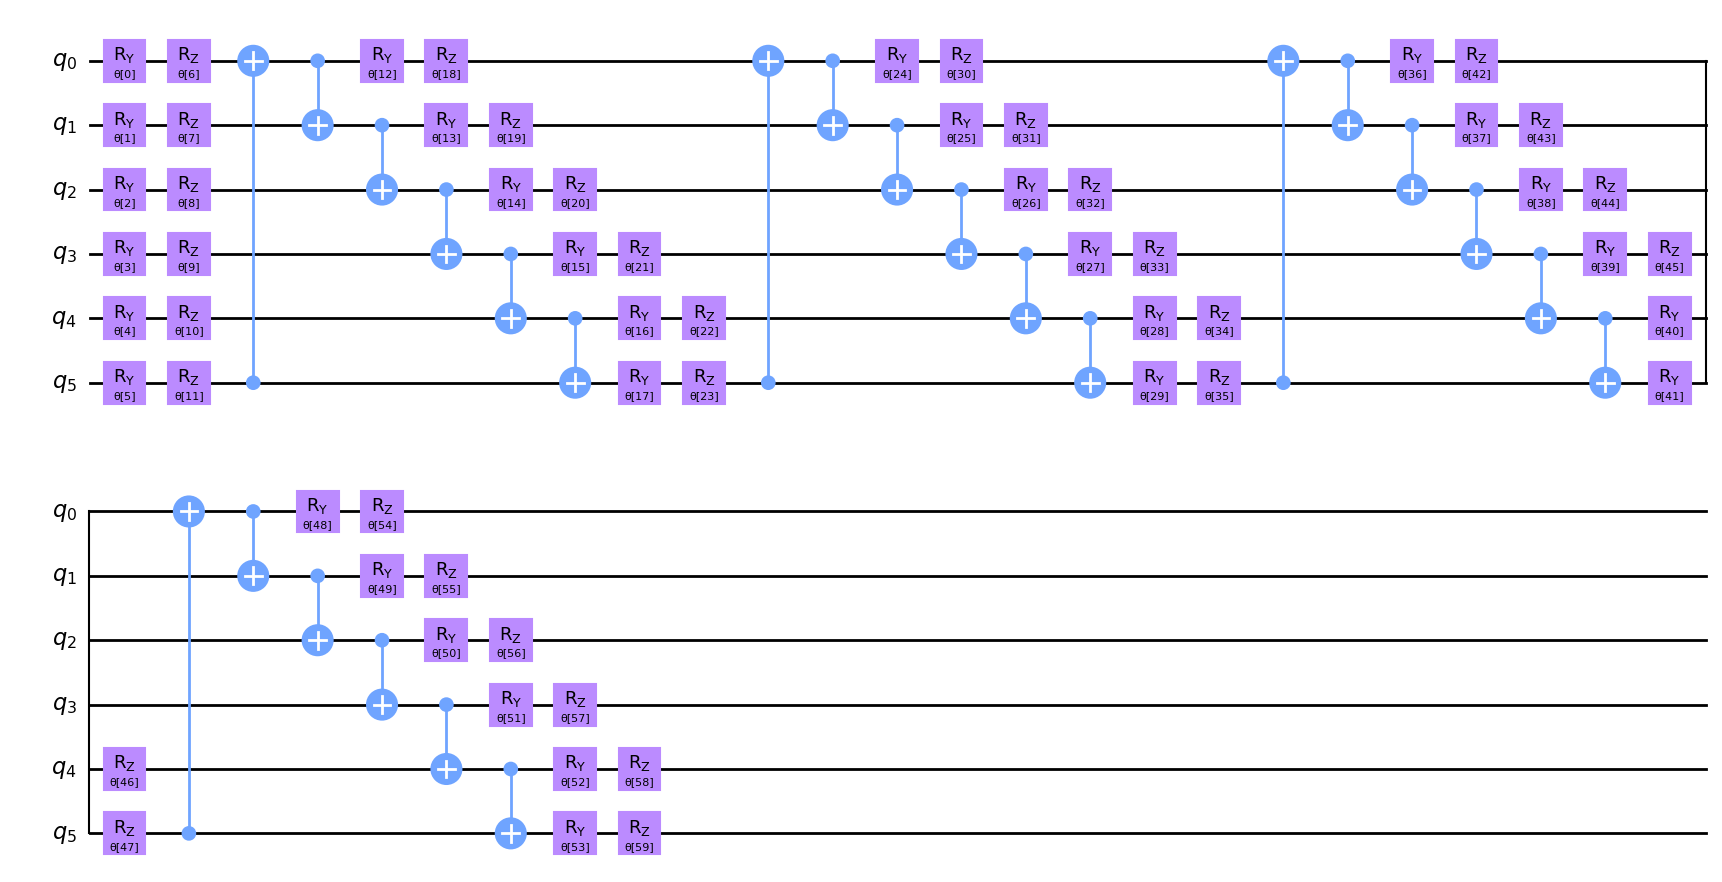

In [25]:
ansatz_SU.draw('mpl')

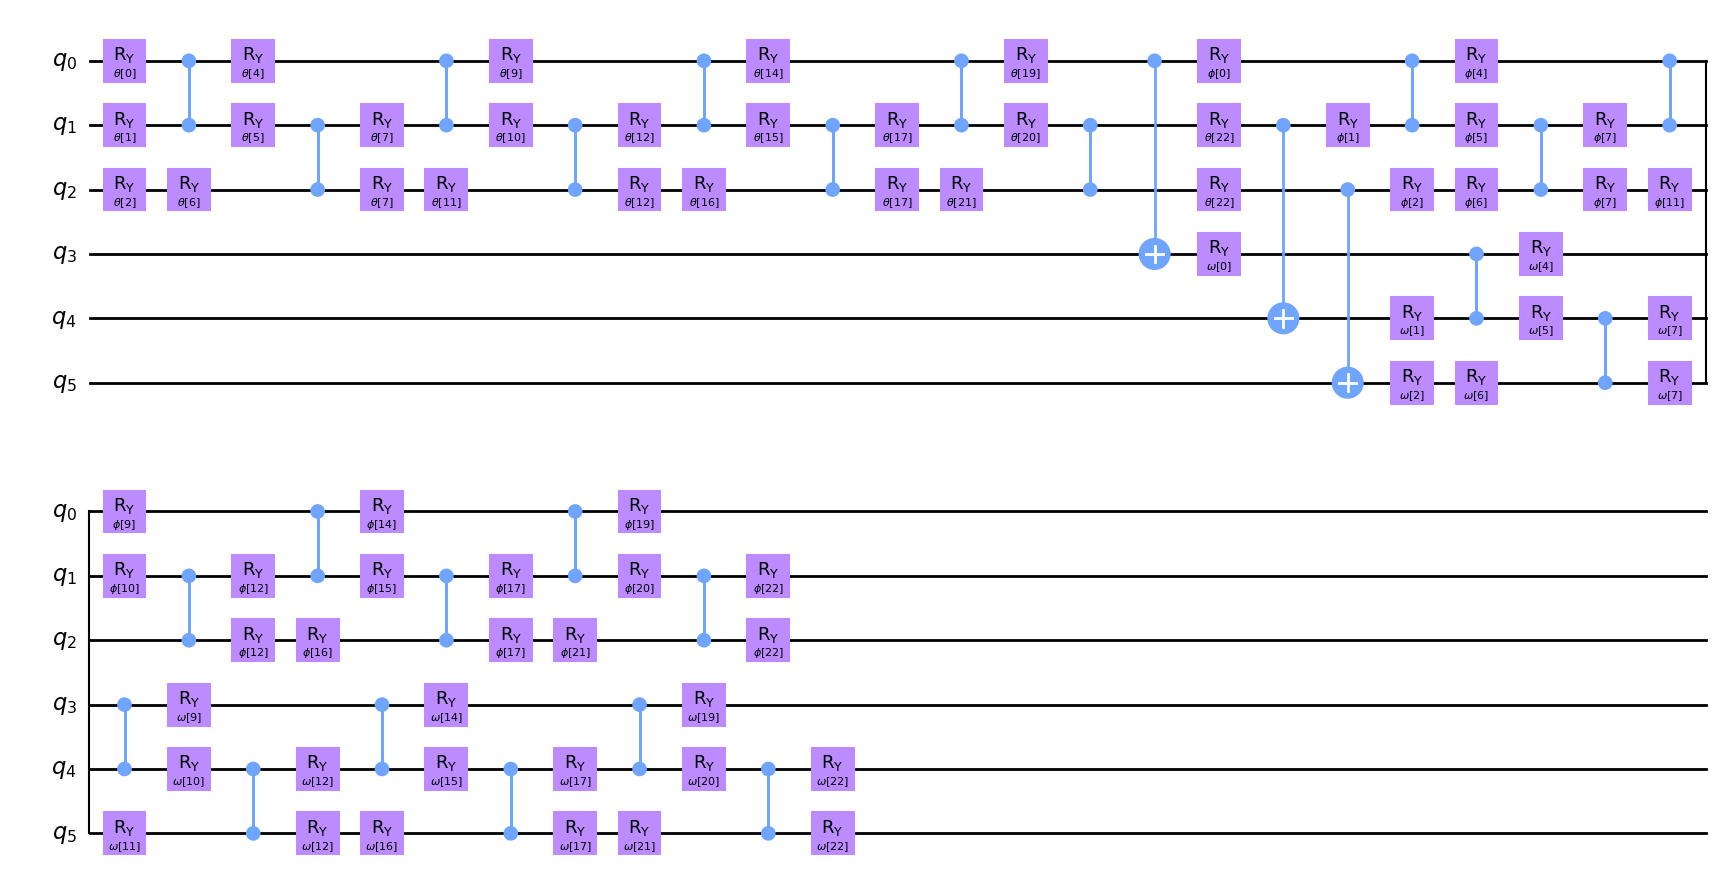

In [26]:
ansatz_SEA.decompose().draw( 'mpl' )

Finally we define the number of iterations of the SPSA optimizer and set the initial paramateres of the VQE as random values of pi.

In [27]:
num_iters = 250
pars_SU  = np.random.rand(t_ansatz_SU.num_parameters) * np.pi
pars_SEA = np.random.rand(t_ansatz_SEA.num_parameters) * np.pi

__NOW WE ARE READY TO RUN OUR VQE !__

We use both the SEA and the SU(2) circuits on the experimental (results) and the exact (data) backend.

In [28]:
results_SU  = VQE( hamiltonian,  t_ansatz_SU,  pars_SU, num_iters, experimental_quantum_instance)
data_SU     = [ energy_evaluation( hamiltonian, t_ansatz_SU, x, exact_quantum_instance ) for x in results_SU['x'] ]

In [29]:
results_SEA = VQE( hamiltonian, t_ansatz_SEA, pars_SEA, num_iters, experimental_quantum_instance)
data_SEA    = [ energy_evaluation( hamiltonian, t_ansatz_SEA, x, exact_quantum_instance ) for x in results_SEA['x'] ]

Now we plot the experimental evaluation value of both the efficient SU(2) and the State Efficient Ansatz a long the iterations.

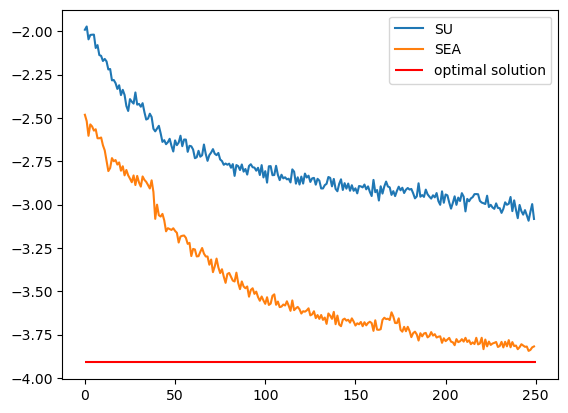

In [32]:
plt.plot( results_SU['fx'], label='SU' )
plt.plot( results_SEA['fx'], label='SEA' )
plt.hlines( exact_energy.real, 0, num_iters, 'r', label='optimal solution' )
plt.legend(  )

The data has some noise so we also plot the exact value of both circuits.

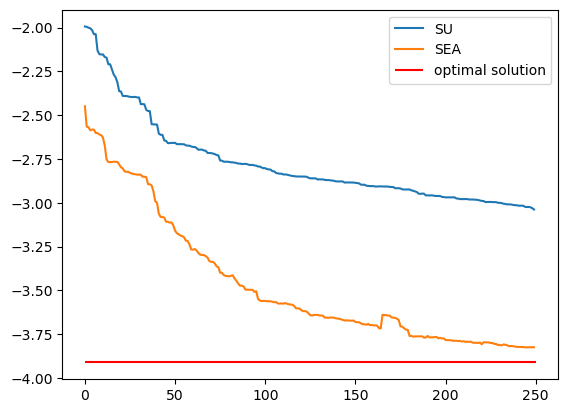

In [33]:
plt.plot( data_SU, label='SU' )
plt.plot( data_SEA, label='SEA' )
plt.hlines( exact_energy.real, 0, num_iters, 'r', label='optimal solution' )
plt.legend(  )

We can see that using the SEA outperform the barren plateau.

### __Reference__

[1] Mitigating barren plateaus of variational quantum eigensolvers, arXiv:2205.13539v2 (2022).